In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [2]:
df = pd.read_csv("./data/BTCUSDT_1h.csv")

In [3]:
df = df.sort_values('close_time')
features = ['open', 'high', 'low', 'close', 'volume']
data = df[features].values

In [4]:
# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
# Create sequences
def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])
    return np.array(sequences)

SEQ_LEN = 24  # e.g., 24 hourly steps
X = create_sequences(data_scaled, SEQ_LEN)

In [6]:
# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)

# Split into training and validation datasets
X_train, X_val = train_test_split(X_tensor, test_size=0.1, shuffle=False)

# DataLoader for batching
train_loader = DataLoader(TensorDataset(X_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val), batch_size=32, shuffle=False)

In [7]:
import torch.nn as nn
import torch.optim as optim

class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(LSTM_Autoencoder, self).__init__()
        self.seq_len = seq_len
        
        # Encoder
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)
        
        self.fc = nn.Linear(input_dim, input_dim)
    
    def forward(self, x):
        batch_size = x.size(0)

        # Encoder
        _, (hidden, _) = self.encoder(x)

        # Repeat the hidden state SEQ_LEN times
        decoder_input = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2)  # [batch_size, seq_len, hidden_dim]

        # Decoder
        decoded, _ = self.decoder(decoder_input)

        # Project back to original feature space
        decoded = self.fc(decoded)
        return decoded

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        """
        patience: Number of epochs with no improvement after which training will be stopped
        delta: Minimum change to qualify as an improvement
        verbose: Whether to print messages when stopping
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = np.inf
        self.counter = 0
        self.stop_training = False

    def __call__(self, val_loss):
        """
        Calls the early stopping mechanism by checking if validation loss has improved
        """
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter since we have improved
        else:
            self.counter += 1
        
        if self.counter >= self.patience:
            self.stop_training = True
            if self.verbose:
                print(f"Early stopping triggered after {self.patience} epochs without improvement.")

        return self.stop_training

In [9]:
# Initialize model
input_dim = X.shape[2]  # Number of features
hidden_dim = 64  # Size of the LSTM hidden layer

model = LSTM_Autoencoder(input_dim, hidden_dim, SEQ_LEN)

In [10]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [11]:
# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)



C:\Users\josiw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
early_stopping = EarlyStopping(patience=5, delta=0.001, verbose=True)


In [13]:
# Function to compute RMSE (Root Mean Squared Error)
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

# Function to compute MAE (Mean Absolute Error)
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

In [14]:
# Training loop
num_epochs = 50

train_losses, val_losses, lrs, rmse_values, mae_values = [], [], [], [], []


In [15]:
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_rmse = 0.0
    epoch_mae = 0.0

    lr = optimizer.param_groups[0]['lr']

    for batch in train_loader:
        X_batch = batch[0]
        
        # Forward pass
        optimizer.zero_grad()
        output = model(X_batch)
        
        # Compute loss
        loss = criterion(output, X_batch)
        

        epoch_rmse += rmse(X_batch, output).item()
        epoch_mae += mae(X_batch, output).item()
        

        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_rmse = epoch_rmse / len(train_loader)
    avg_mae = epoch_mae / len(train_loader)
    
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_rmse = 0.0
    epoch_val_mae = 0.0


    with torch.no_grad():
        for batch in val_loader:
            X_batch = batch[0]
            output = model(X_batch)

            loss = criterion(output, X_batch)
            epoch_val_loss += loss.item()
            
            # Compute validation RMSE and MAE
            epoch_val_rmse += rmse(X_batch, output).item()
            epoch_val_mae += mae(X_batch, output).item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_val_rmse = epoch_val_rmse / len(val_loader)
    avg_val_mae = epoch_val_mae / len(val_loader)

    # Calculate the average loss
    avg_train_loss = epoch_train_loss / len(train_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    lrs.append(lr)
    rmse_values.append(avg_val_rmse)
    mae_values.append(avg_val_mae)
    
    # Step the learning rate scheduler
    lr_scheduler.step(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    print(f'\tRMSE (Train): {avg_rmse:.4f}, RMSE (Val): {avg_val_rmse:.4f}')
    print(f'\tMAE (Train): {avg_mae:.4f}, MAE (Val): {avg_val_mae:.4f}')    
    
    if early_stopping(avg_val_loss):
        print(f"Training stopped at epoch {epoch+1} due to early stopping.")
        break

Epoch [1/50], Train Loss: 0.0038, Val Loss: 0.0013
	RMSE (Train): 0.0409, RMSE (Val): 0.0331
	MAE (Train): 0.0236, MAE (Val): 0.0249
Epoch [2/50], Train Loss: 0.0003, Val Loss: 0.0007
	RMSE (Train): 0.0174, RMSE (Val): 0.0252
	MAE (Train): 0.0081, MAE (Val): 0.0196
Epoch [3/50], Train Loss: 0.0003, Val Loss: 0.0011
	RMSE (Train): 0.0166, RMSE (Val): 0.0323
	MAE (Train): 0.0074, MAE (Val): 0.0286
Epoch [4/50], Train Loss: 0.0003, Val Loss: 0.0006
	RMSE (Train): 0.0164, RMSE (Val): 0.0237
	MAE (Train): 0.0073, MAE (Val): 0.0196
Epoch [5/50], Train Loss: 0.0003, Val Loss: 0.0014
	RMSE (Train): 0.0161, RMSE (Val): 0.0338
	MAE (Train): 0.0068, MAE (Val): 0.0301
Epoch [6/50], Train Loss: 0.0003, Val Loss: 0.0004
	RMSE (Train): 0.0160, RMSE (Val): 0.0184
	MAE (Train): 0.0067, MAE (Val): 0.0135
Early stopping triggered after 5 epochs without improvement.
Training stopped at epoch 6 due to early stopping.


In [16]:
# Compute reconstruction error on validation set
model.eval()
reconstruction_errors = []
with torch.no_grad():
    for batch in val_loader:
        X_batch = batch[0]
        output = model(X_batch)
        loss = torch.mean((output - X_batch) ** 2, dim=(1,2))  # MSE for each sequence
        reconstruction_errors.extend(loss.numpy())

num_sequences = len(X)

# Get number of validation samples
num_val = len(X_val)

# Find the starting index in the original DataFrame
val_start_idx = num_sequences - num_val

# Align the original dataframe accordingly
df_plot = df.iloc[SEQ_LEN + val_start_idx:].copy()

# Add reconstruction errors
df_plot['reconstruction_error'] = reconstruction_errors

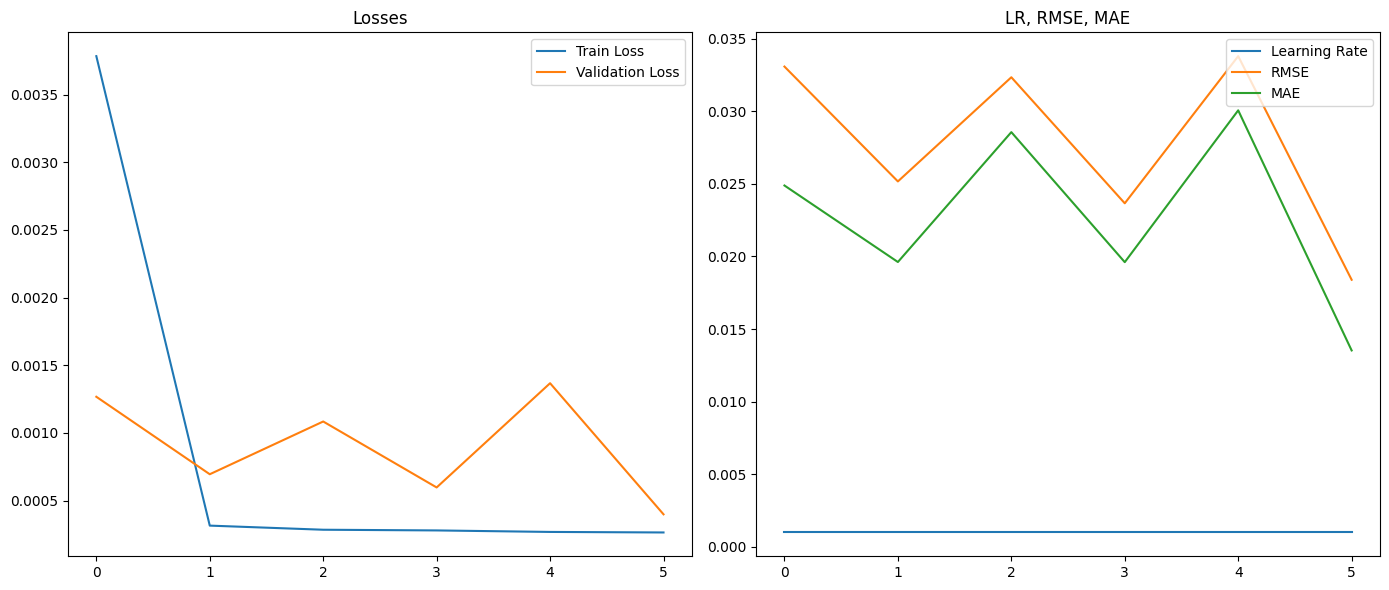

In [17]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning Rate')
plt.plot(rmse_values, label='RMSE')
plt.plot(mae_values, label='MAE')
plt.legend()
plt.title('LR, RMSE, MAE')
plt.tight_layout()
plt.show()

In [18]:
model.eval()
reconstructions = []
errors = []

with torch.no_grad():
    for batch in DataLoader(TensorDataset(X_tensor), batch_size=32, shuffle=False):
        X_batch = batch[0]
        output = model(X_batch)
        reconstructions.append(output)
        
        # Per-sequence error (MSE)
        batch_errors = torch.mean((output - X_batch) ** 2, dim=(1, 2))  # mean over seq_len and features
        errors.append(batch_errors)

reconstructions = torch.cat(reconstructions)
errors = torch.cat(errors).numpy()  # Shape: [num_sequences]


In [19]:
threshold = np.percentile(errors, 95)  # Top 5% as anomalies


In [20]:
anomalies = errors > threshold


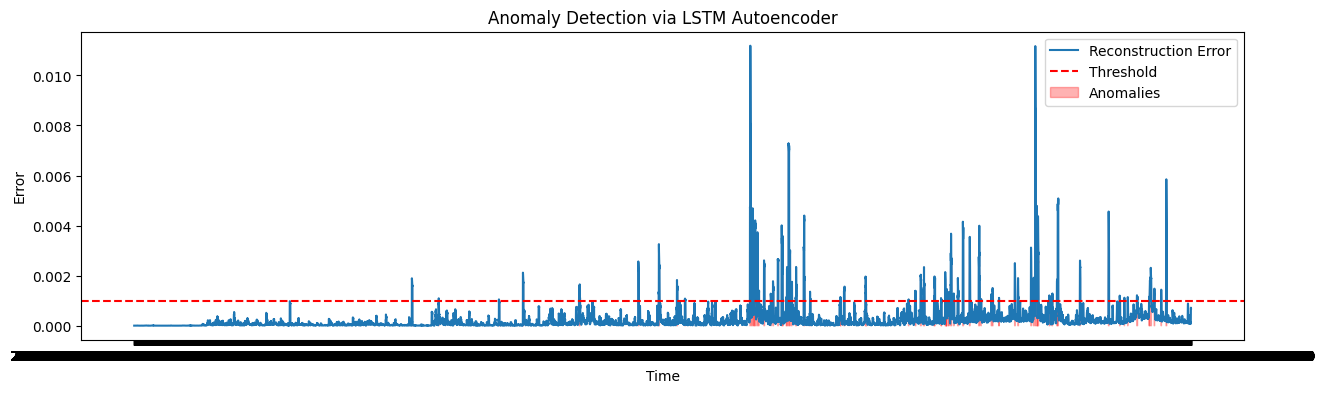

In [22]:
import matplotlib.pyplot as plt

timestamps = df['close_time'].values[SEQ_LEN:]  # align with sequences

plt.figure(figsize=(15, 4))
plt.plot(timestamps, errors, label="Reconstruction Error")
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
plt.fill_between(timestamps, 0, errors, where=anomalies, color='red', alpha=0.3, label="Anomalies")
plt.legend()
plt.title("Anomaly Detection via LSTM Autoencoder")
plt.xlabel("Time")
plt.ylabel("Error")
plt.show()
